### MMA 860 Team Project: Predicting Housing Prices

Team Istanbul

In [113]:
# %pip install openpyxl
# %matplotlib inline
# %pip install statsmodels
# %pip install scikit-learn seaborn
# %pip install jupyter_contrib_nbextensions

In [114]:
import pandas as pd
import numpy as np

import statsmodels.imputation.mice as mice
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
 
from sklearn import linear_model
#import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
#Converting data source to dataframes
file_path_test  = "test.csv"
file_path_train = "train.csv"

df_test  = pd.read_csv(file_path_test, index_col="Id")
df_train = pd.read_csv(file_path_train, index_col="Id")

In [116]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### UDFs

### Project Code

#### Data Cleaning
1. Check for nulls
2. Check of data-type inconsistencies
3. Check for duplicate rows
4. Check for outliers
5. Test for biases after imputations


In [96]:
#checking for datatype
print(df_test.dtypes)

#Print column with inconsistent datatypes (if any)
for col in df_test.columns:
    unique_types = set(df_test[col].dropna().apply(type)) 
    if len(unique_types) > 1:
        print(f"Column '{col}' has inconsistent data types: {unique_types}")

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object


In [97]:
df_test.shape

(1459, 79)

In [98]:
#check for duplicates
duplicate_count = df_test.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [99]:
cols = df_test.columns.tolist()

#Checking column names; removing spaces from name
for col in cols:
    if ' ' in col:
        new_col = col.replace(' ', '')
        print(f"Removing space in {col}: new name {new_col}")
        
        df_test.rename(columns={col: new_col}, inplace=True)

In [100]:
#Checking if any columns are completely empty
for col in cols:
    if df_test[col].astype(str).str.strip().eq('').all():
        print(f"Column {col} is empty. To be deleted...")

In [101]:
#Checking for nulls in columns (grouped by datatype)

#Initializing lists to store column names with null values
col_num_nulls = []
col_obj_nulls = []

for dtype in sorted(df_test.dtypes.unique(), key=str):  
    
    # Select columns of the current data type and sort by null count
    cols = [col for col in df_test.columns if df_test[col].dtypes == dtype]
    sorted_cols = sorted(cols, key=lambda col: df_test[col].isnull().sum(), reverse=True)
    
    if df_test[col].isnull().sum() == 0:
        print(f"------------- {dtype} -------------")
    
    # Print columns and their respective null counts
    for col in sorted_cols:
        null_count = df_test[col].isnull().sum()
        if null_count > 0:
            print(f"{col} : {null_count}")
            
            #Storing column names in the lists
            if dtype == 'object':
                col_obj_nulls.append(col)
            else:
                col_num_nulls.append(col)

    print("\n")

------------- float64 -------------
LotFrontage : 227
GarageYrBlt : 78
MasVnrArea : 15
BsmtFullBath : 2
BsmtHalfBath : 2
BsmtFinSF1 : 1
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
GarageCars : 1
GarageArea : 1




------------- object -------------
PoolQC : 1456
MiscFeature : 1408
Alley : 1352
Fence : 1169
FireplaceQu : 730
GarageFinish : 78
GarageQual : 78
GarageCond : 78
GarageType : 76
BsmtCond : 45
BsmtQual : 44
BsmtExposure : 44
BsmtFinType1 : 42
BsmtFinType2 : 42
MasVnrType : 16
MSZoning : 4
Utilities : 2
Functional : 2
Exterior1st : 1
Exterior2nd : 1
KitchenQual : 1
SaleType : 1




<h6 style="color: #ff5733;">Null Count Findings:</h6>

1. No spaces found in column names. 
2. There are no columns that are completely empty. 
3. There are no duplicate rows.

**Float Data Type**
1. There are 11 float type columns with null values. 
2. The maximum number of null values in a column are 227. 
3. All null values can be populated using multiple imputations

**Object Data Type**
1. There are 22 object type columns with null values. 
2. There are 4 columns that are more than 45% empty (i.e. less than 55% populated), therefore these columns must be deleted to prevent model skewing:
| Column | Null Values | Percent Empty |
| --- | --- | --- |
| PoolQC | 1456 | 99.8% |
| MiscFeature | 1408 | 96.5% |
| Alley | 1352 | 92.7% |
| Fence | 1169 | 80.1% |
| FireplaceQu | 730 | 50% |
3. For the remainder columns, the mode will of the column will be used to populate the empty values

In [112]:
#Running multiple imputations on numeric columns 

df_numeric = df_test.loc[:, col_num_nulls]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

#Checking the maximum % of records with missing data and using the higher of that or 5
missing     = (df_numeric.isnull().sum().max() / len(df_numeric)) * 100
imputations = max(5, int(missing))

#Running regression with imputed data
frmla       = "SalePrice ~ " + "+".join(df_test.columns.drop(["SalesPrice"]))

#imputed_data = imp.data

mice        = mice.MICE(frmla, sm.OLS, imp)
results     = mice.fit(n_imputations = imputations)

# Update df_test with the imputed values
for col in df_numeric.columns:
    df_test[col] = df_test[col].where(df_test[col].notnull(), imputed_data[col])

KeyError: "['SalesPrice'] not found in axis"

In [104]:
#Dropping columns that more than 45% empty 
df_test = df_test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

<h5 style="color: blue;">Numeric Columns</h5>

1. Test numeric columns
2. Clean and add data wherever necessary

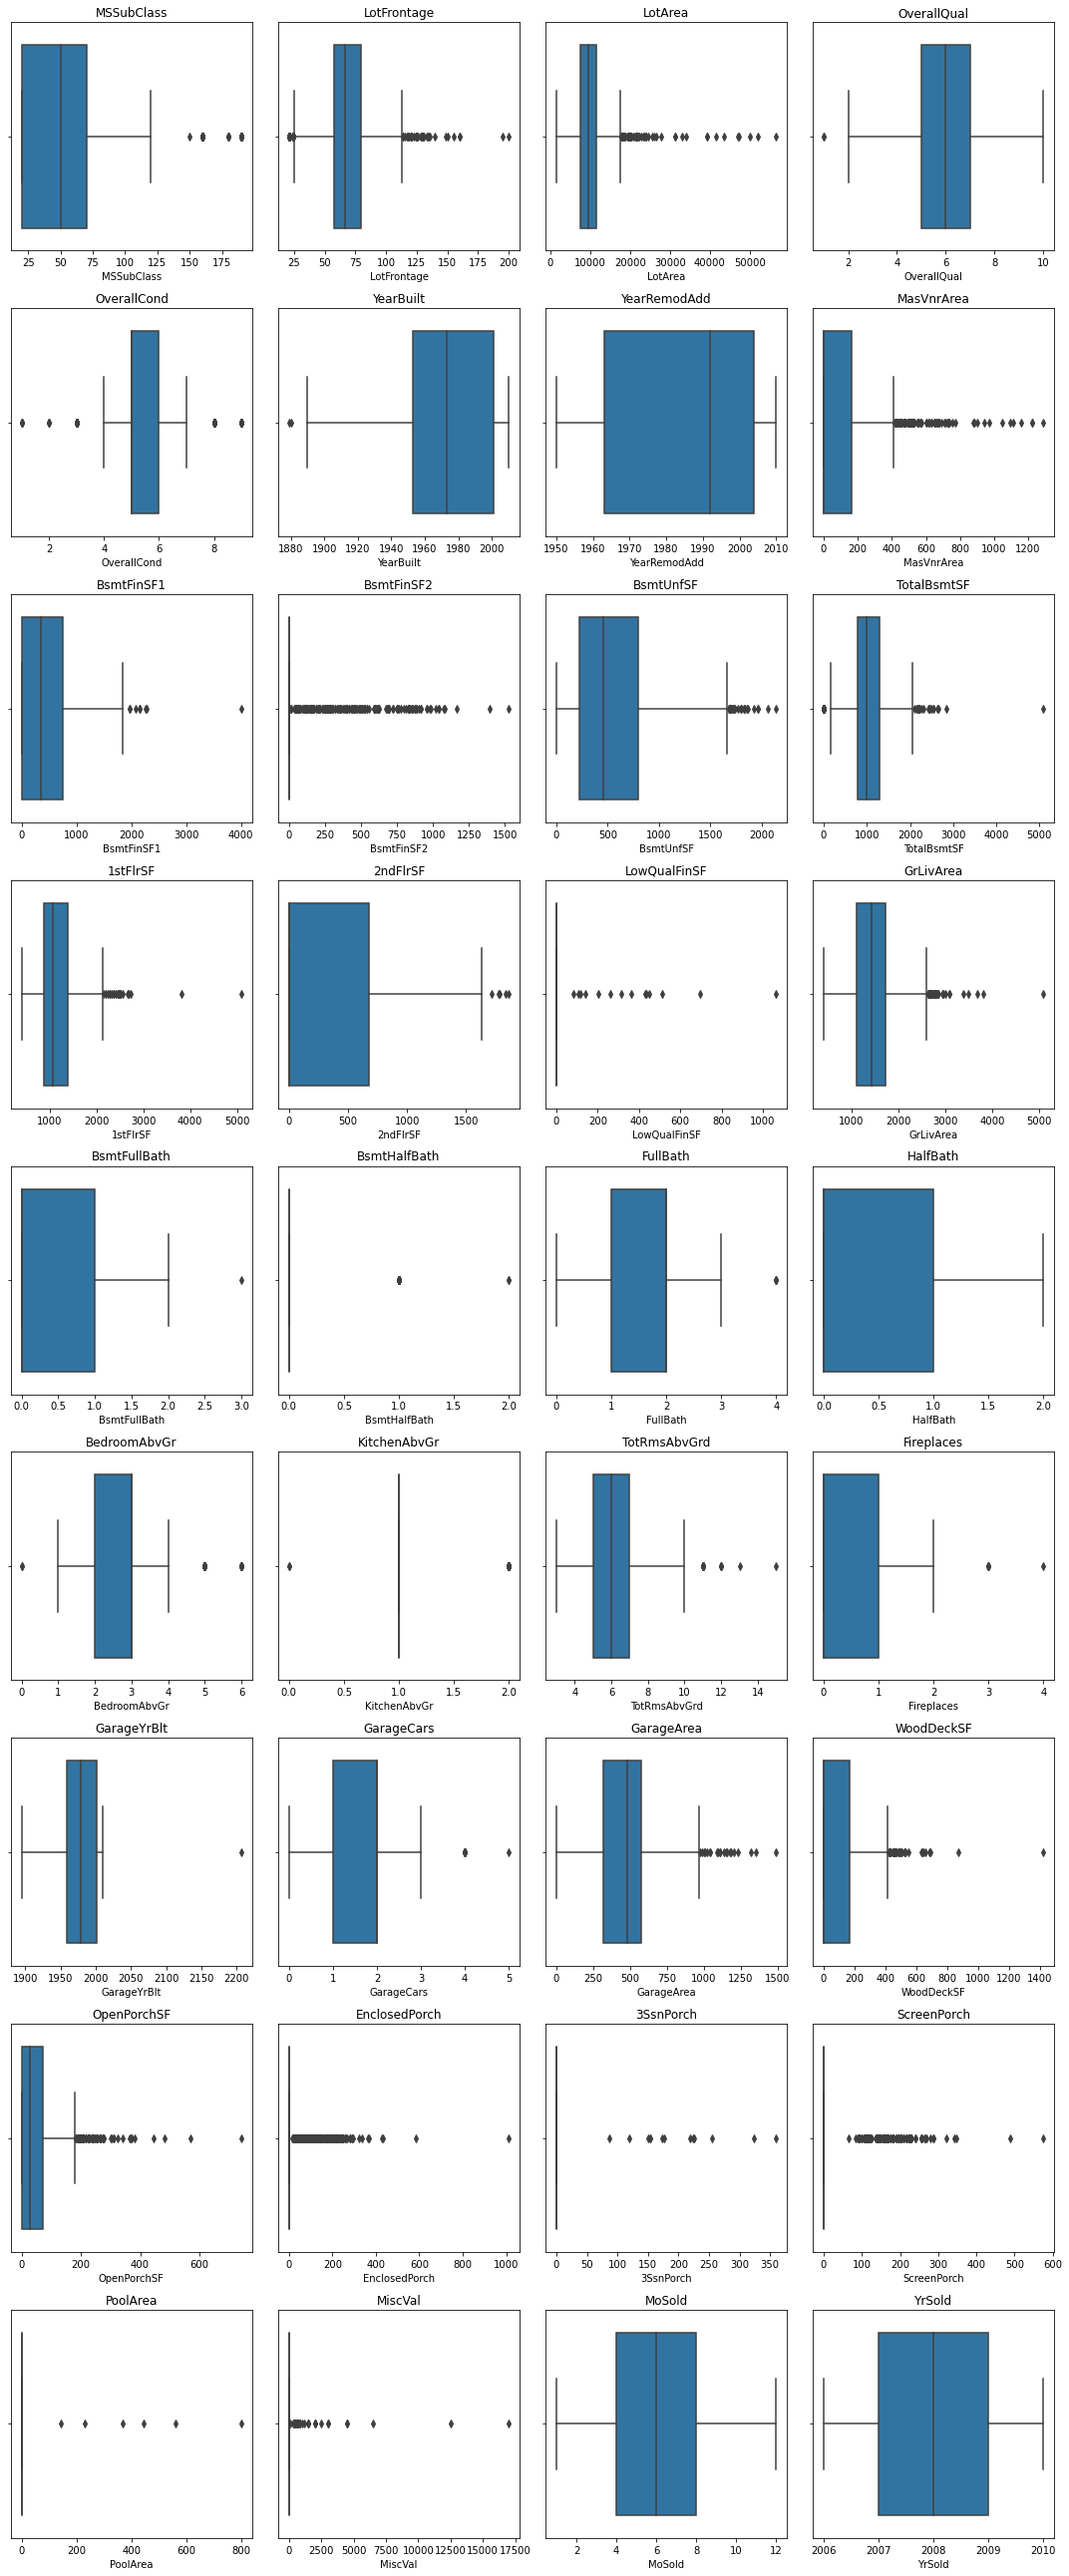

In [62]:
num_cols = df_test.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the number of plots per row
plots_per_row = 4
num_cols_count = len(num_cols)
rows = (num_cols_count // plots_per_row) + (num_cols_count % plots_per_row > 0) 

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Box plot for each numeric column
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_test[col], ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

<h6 style="color: #ff5733;">Outlier Findings:</h6>

A lot numeric columns contain outliers (as can be seen in the box and whisker plots), however it isn't necessary to remove the outliers because:
1. **Area columns:** For features related to area, the value of 0 is the most frequent value, representing unfinished or non-existent features. In these cases, other values are technically outliers, but 0 simply indicates the absence of that feature. Removing them would misrepresent the data.
2. **Condition columns:** These columns contain ratings for various aspects of the house, such as its condition. While extreme low or high ratings may appear as outliers, they actually reflect the true condition of the house. Removing these values would distort the representation of house conditions.

<h5 style="color: blue;">Categorical Columns</h5>

1. Test categorical columns
2. Clean and add data wherever necessary

In [29]:
#Checking for distinct values in all colums of datatype 'object'
cat_cols = df_test.select_dtypes(include=['object']).columns.tolist()

# 
for col in cat_cols:
    print(f"In column {col}: ")
    print(df_test[col].unique())
    print("\n")

In column MSZoning: 
['RH' 'RL' 'RM' 'FV' 'C (all)' nan]


In column Street: 
['Pave' 'Grvl']


In column LotShape: 
['Reg' 'IR1' 'IR2' 'IR3']


In column LandContour: 
['Lvl' 'HLS' 'Bnk' 'Low']


In column Utilities: 
['AllPub' nan]


In column LotConfig: 
['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']


In column LandSlope: 
['Gtl' 'Mod' 'Sev']


In column Neighborhood: 
['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']


In column Condition1: 
['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']


In column Condition2: 
['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']


In column BldgType: 
['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']


In column HouseStyle: 
['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf']


In column RoofStyle: 
['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'She

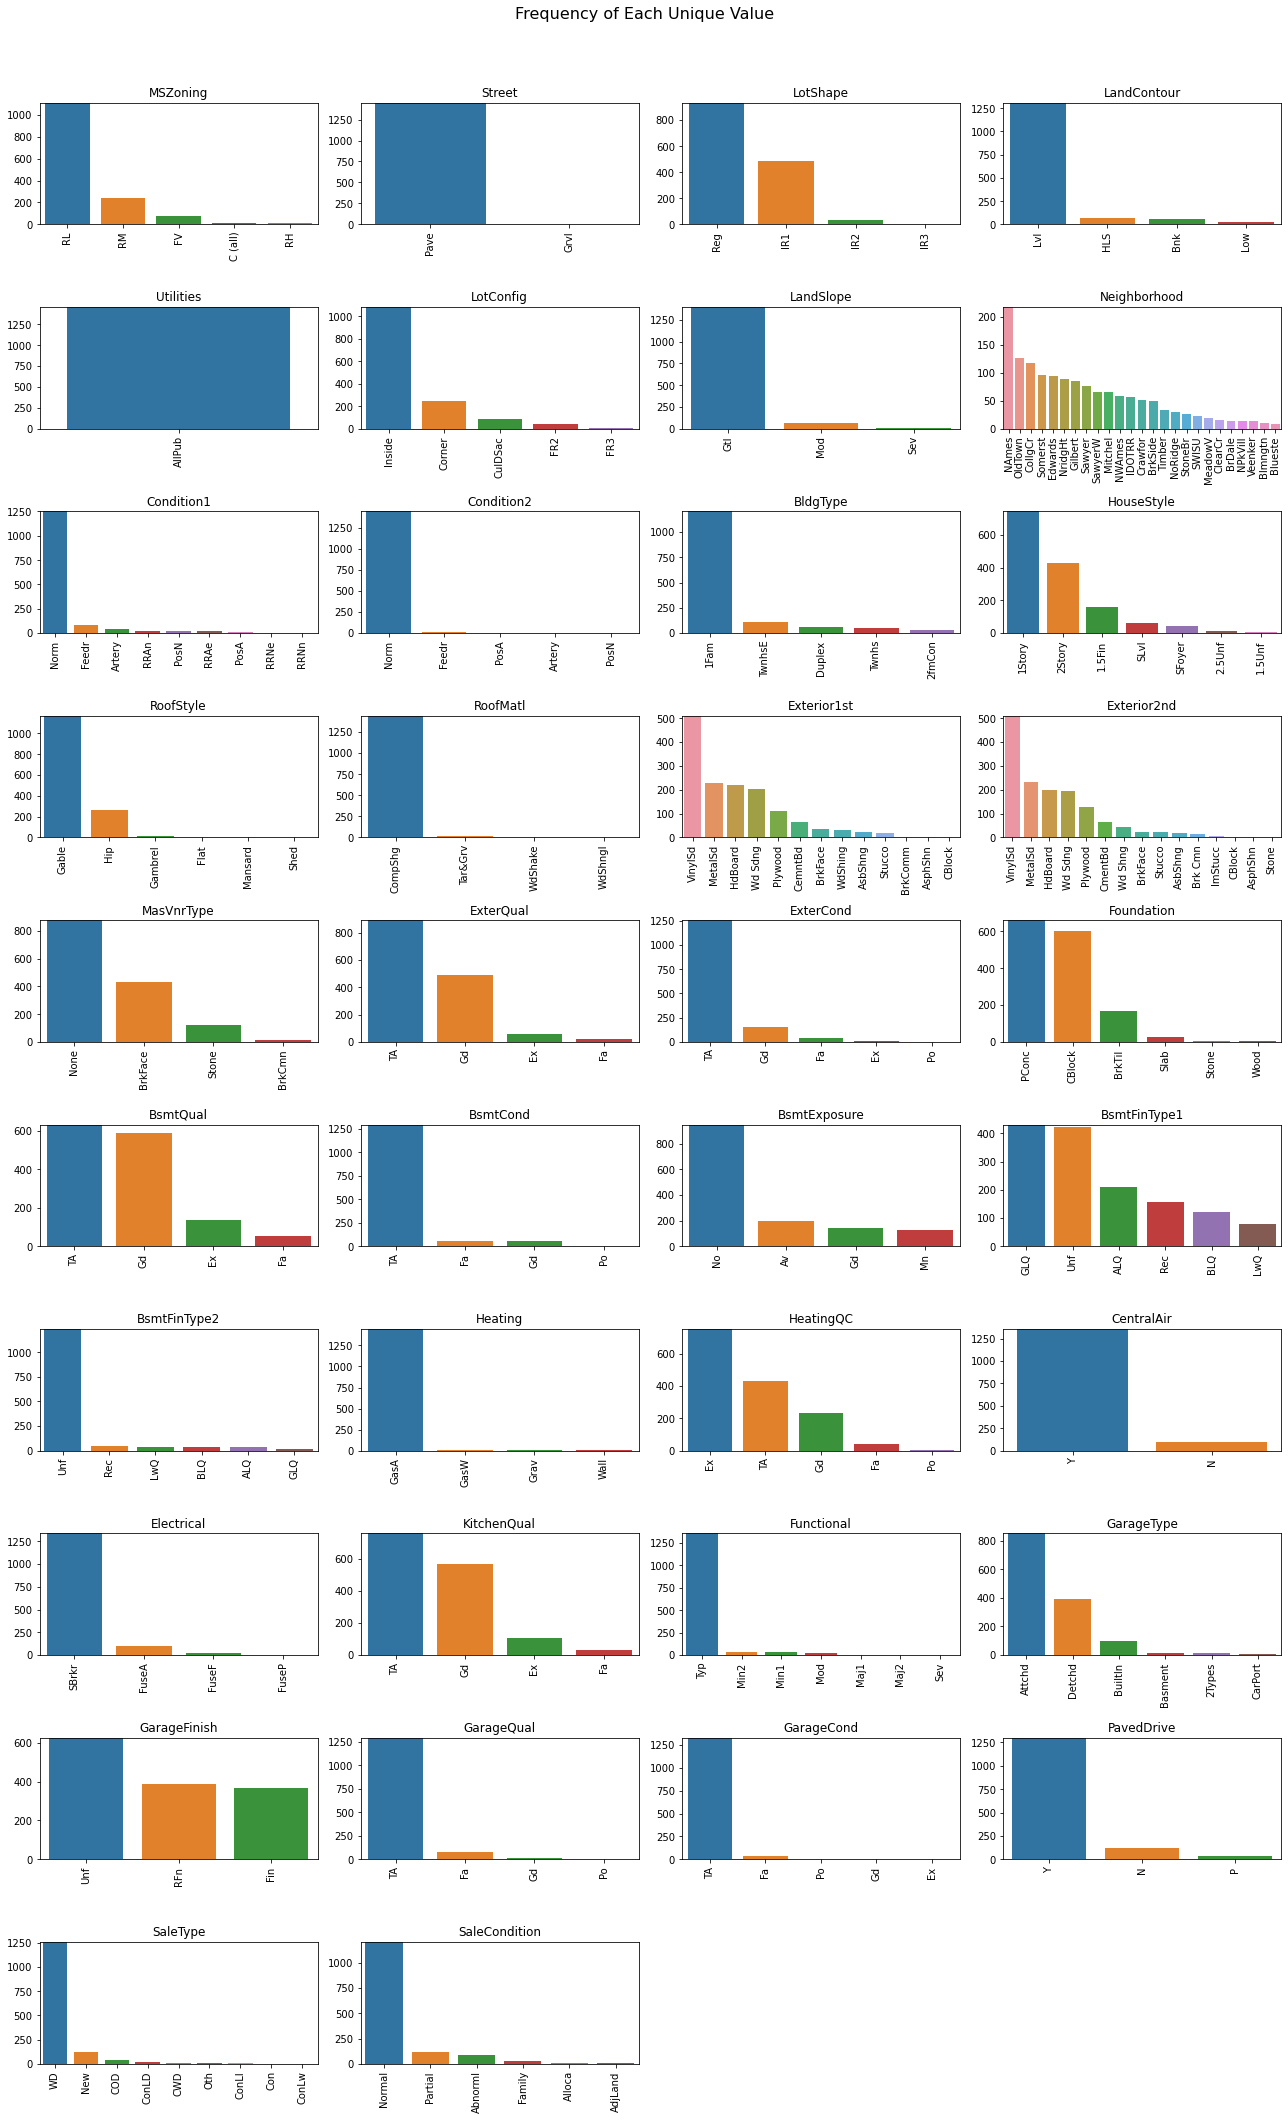

In [30]:
#Plotting the frequency of each unique value
cols = df_test.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Frequency of Each Unique Value', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    count = df_test[col].value_counts()
    
    sns.barplot(x = count.index, y = count.values)
    
    plt.ylim(0, count.max())
    index +=1
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Exploratory Data Analysis
1. Statistical analysis of variables


#### Feature Engineering
1. Dummy variables/One Hot Encoding
2. Test variable significance
3. Collinearity analysis
4. Dimension reduction

#### Predictive Modelling
1. Multiple Lineaer Regression
2. Heteroskedascity analysis
3. Hypothesis Testing
4. MAE and RMSE analysis

In [ ]:
# # Split our preprocessed data into our features and target arrays
# y = application_df['IS_SUCCESSFUL'].values
# X = application_df.drop(['IS_SUCCESSFUL'],1).values
# # Split the preprocessed data into a training and testing dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# # Create a StandardScaler instances
# scaler = StandardScaler()

# # Fit the StandardScaler
# X_scaler = scaler.fit(X_train)

# # Scale the data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# # Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# number_input_features = len(X_train[0])
# hidden_nodes_layer1 = 80
# hidden_nodes_layer2 = 30

# nn = tf.keras.models.Sequential()

# # First hidden layer
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, 
#                              input_dim = number_input_features, 
#                              activation = "relu"))

# # Second hidden layer
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, 
#                              activation = "relu"))

# # Output layer
# nn.add(tf.keras.layers.Dense(units = 1, 
#                              activation = "sigmoid"))

# # Check the structure of the model
# nn.summary()